# Set- Up

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import collections # For frequency counting
import findspark
findspark.init("/home/shahan/Downloads/spark2")

import pyspark
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import lit # Create columns of *literal* value
from pyspark.sql.functions import col # Returns a Column based on the 
                                      # given column name
from pyspark.ml.feature import StringIndexer #label encoding
from pyspark.ml import Pipeline

sc = pyspark.SparkContext(appName="helloworld")

# Spark Session

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Data

In [210]:
trainDF = spark.read.csv("/home/shahan/Documents/Spark/Data/train.csv", header="true")
testDF = spark.read.csv("/home/shahan/Documents/Spark/Data/test.csv", header="true")

## Combine train and Test Data

In [211]:
## Add Survived column to test, and dataset name as a column
trainDF = trainDF.withColumn('Mark', lit('train'))
testDF = (testDF.withColumn('Survived',lit(0))
                .withColumn('Mark', lit('test')))
testDF = testDF[trainDF.columns]

## Append Test data to Train data
df = trainDF.unionAll(testDF)

In [212]:
df.createOrReplaceTempView("train")

### Convert variables to numeric

In [213]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)



Variables that should be numeric are:

PassengerId: Integer
Pclass: Integer
SibSp: Integer
Parch: Integer
Survived: Integer
Age: Float
Fare: Float


In [214]:
# Function to convert the data to any type

def to_anytype(df, colnames, typename):
    for colname in colnames:
        df = df.withColumn("tmp", df[colname].cast(typename)) \
        .drop(colname) \
        .withColumnRenamed("tmp", colname)
    return(df)


In [215]:
#Changing the types as follows
intCols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Survived']
floatCols = ['Age', 'Fare']

df = to_anytype(df, intCols, "integer")
df = to_anytype(df, floatCols, "float")

In [216]:
#checking
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Fare: float (nullable = true)



# Histogram

In [217]:
#trying to make histogram, but Age variable is not in proper format
age_hist = spark.sql(
    "SELECT Age AS age, \
            count(*) AS count \
    FROM train \
    GROUP BY Age \
    ORDER BY Age")
age_hist.show(n=age_hist.count())

+----+-----+
| age|count|
+----+-----+
|    |  263|
|0.17|    1|
|0.33|    1|
|0.42|    1|
|0.67|    1|
|0.75|    3|
|0.83|    3|
|0.92|    2|
|   1|   10|
|  10|    4|
|  11|    4|
|11.5|    1|
|  12|    3|
|  13|    5|
|  14|    8|
|14.5|    2|
|  15|    6|
|  16|   19|
|  17|   20|
|  18|   39|
|18.5|    3|
|  19|   29|
|   2|   12|
|  20|   23|
|20.5|    1|
|  21|   41|
|  22|   43|
|22.5|    1|
|  23|   26|
|23.5|    1|
|  24|   47|
|24.5|    1|
|  25|   34|
|  26|   30|
|26.5|    1|
|  27|   30|
|  28|   32|
|28.5|    3|
|  29|   30|
|   3|    7|
|  30|   40|
|30.5|    2|
|  31|   23|
|  32|   24|
|32.5|    4|
|  33|   21|
|  34|   16|
|34.5|    2|
|  35|   23|
|  36|   31|
|36.5|    2|
|  37|    9|
|  38|   14|
|38.5|    1|
|  39|   20|
|   4|   10|
|  40|   18|
|40.5|    3|
|  41|   11|
|  42|   18|
|  43|    9|
|  44|   10|
|  45|   21|
|45.5|    2|
|  46|    6|
|  47|   14|
|  48|   14|
|  49|    9|
|   5|    5|
|  50|   15|
|  51|    8|
|  52|    6|
|  53|    4|
|  54|   10|

In [218]:
#Creating Buckets
age_hist = spark.sql(
    "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(Age/5.00)*5 as bucket_floor, \
            floor(Age/5.00)*5 + 5 as bucket_ceiling \
        FROM train \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1")

age_hist.show(n=age_hist.count())

+------------+-----------+-----+
|bucket_floor|bucket_name|count|
+------------+-----------+-----+
|        null|       null|  263|
|           0|     0 to 5|   51|
|           5|    5 to 10|   31|
|          10|   10 to 15|   27|
|          15|   15 to 20|  116|
|          20|   20 to 25|  184|
|          25|   25 to 30|  160|
|          30|   30 to 35|  132|
|          35|   35 to 40|  100|
|          40|   40 to 45|   69|
|          45|   45 to 50|   66|
|          50|   50 to 55|   43|
|          55|   55 to 60|   27|
|          60|   60 to 65|   27|
|          65|   65 to 70|    5|
|          70|   70 to 75|    6|
|          75|   75 to 80|    1|
|          80|   80 to 85|    1|
+------------+-----------+-----+



In [219]:
# replace None values
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] 
    return(coldata)

age = get_column(age_hist, "bucket_name")
count = get_column(age_hist, "count")

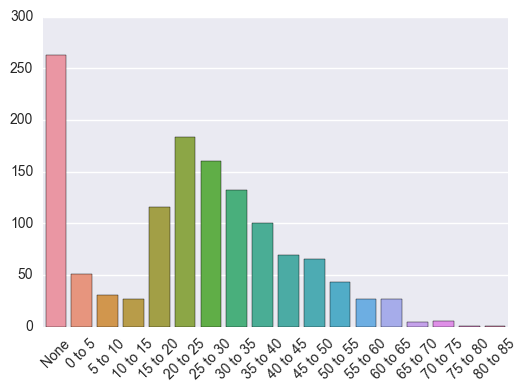

In [220]:
%matplotlib inline

barplt = sns.barplot(age, count)
for item in barplt.get_xticklabels():
    item.set_rotation(45)

## Function for making Histograms

In [221]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

def histplot(dfname, colname, binsize):
    binsize = str(binsize)
    dfname.createOrReplaceTempView("tmpDF")
    hist_query = "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(" + colname + "/" + binsize + ")*" + binsize + " as bucket_floor, \
            floor(" + colname + "/" + binsize + ")*" + binsize + " + " + binsize + " as bucket_ceiling \
        FROM tmpDF \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1"
    hist_data = spark.sql(hist_query)
    xvar = get_column(hist_data, "bucket_name")
    count = get_column(hist_data, "count")
    barplt = sns.barplot(xvar, count)
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

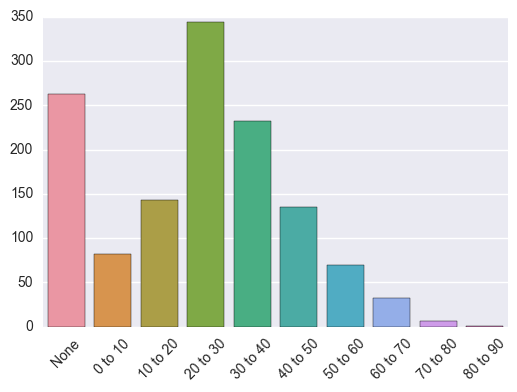

In [222]:
#check
histplot(df, "Age", 10)

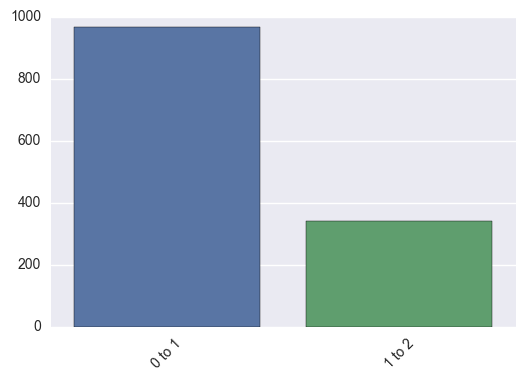

In [223]:
histplot(df, "Survived", 1)

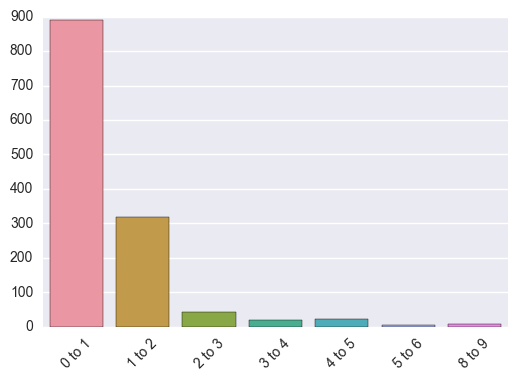

In [224]:
histplot(df, "SibSp", 1)

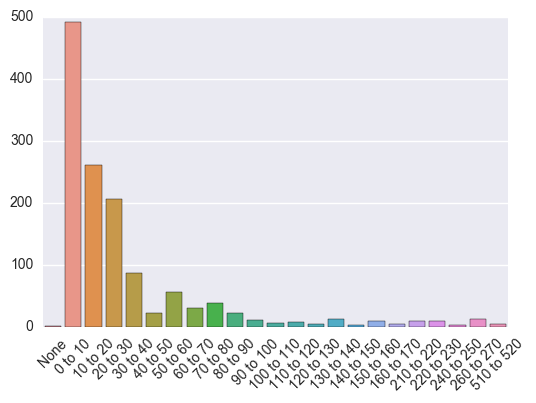

In [225]:
histplot(df, "Fare", 10)

#### This function will not work for Categorical Variables. Hence making another function for categorical variables.

In [226]:
def histplot_s(df, colname):
    xvar = get_column(df, colname)
    counter = collections.Counter(xvar)
    barplt = sns.barplot(list(counter.keys()), list(counter.values()))
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

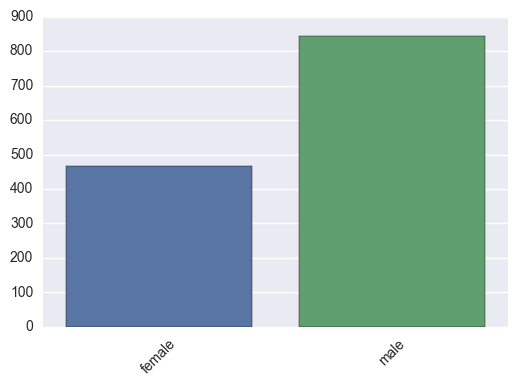

In [227]:
#Testing for categorical variable

histplot_s(df, "Sex")

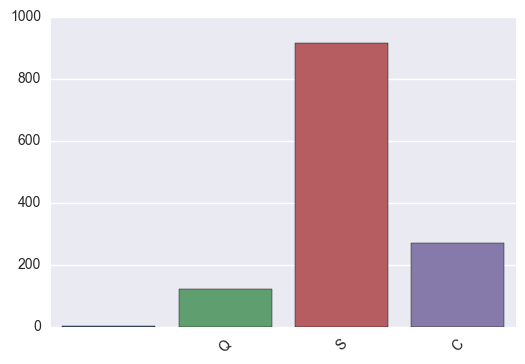

In [228]:
histplot_s(df, "Embarked")

#### Checking for Corelations

In [229]:
# Please note that only Pearson corelation is supported
df.corr("Age", "Fare")

0.21349686667435705

In [230]:
df.corr("Age", "SibSp")

-0.13446462318917687

In [231]:
df.corr("Age", "Parch")

-0.039940130829688975

In [232]:
df_num = df['PassengerId','Pclass','SibSp','Parch','Survived','Age','Fare']

In [233]:
df_num.show(5)

+-----------+------+-----+-----+--------+----+-------+
|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|
+-----------+------+-----+-----+--------+----+-------+
|          1|     3|    1|    0|       0|22.0|   7.25|
|          2|     1|    1|    0|       1|38.0|71.2833|
|          3|     3|    0|    0|       1|26.0|  7.925|
|          4|     1|    1|    0|       1|35.0|   53.1|
|          5|     3|    0|    0|       0|35.0|   8.05|
+-----------+------+-----+-----+--------+----+-------+
only showing top 5 rows



### Missing Value Imputation

In [235]:
#Counts for nulls, blanks etc
numVars = ['Survived','Age','SibSp','Parch','Fare']
stringVars = ['Cabin', 'Embarked', 'Pclass', 'Sex']

def countNull(df,var):
    return df.where(df[var].isNull()).count()

def countEmptyString(df,var):
    return df[df[var].isin("")].count()

def countZero(df,var):
    return df[df[var].isin(0)].count()

In [236]:
missing = {var: countNull(df,var) for var in df.columns}
missing

{'Age': 263,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 1,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [237]:
missing = {var: countEmptyString(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 1014,
 'Embarked': 2,
 'Fare': 0,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [238]:
missing = {var: countZero(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 17,
 'Mark': 0,
 'Name': 0,
 'Parch': 1002,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 891,
 'Survived': 967,
 'Ticket': 0}

In [37]:
df

DataFrame[Name: string, Sex: string, Ticket: string, Cabin: string, Embarked: string, Mark: string, PassengerId: int, Pclass: int, SibSp: int, Parch: int, Survived: int, Age: float, Fare: float]

In [193]:
df_num.take(5)

[Row(PassengerId=1, Pclass=3, SibSp=1, Parch=0, Survived=0, Age=22.0, Fare=7.25),
 Row(PassengerId=2, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=38.0, Fare=71.2833023071289),
 Row(PassengerId=3, Pclass=3, SibSp=0, Parch=0, Survived=1, Age=26.0, Fare=7.925000190734863),
 Row(PassengerId=4, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=35.0, Fare=53.099998474121094),
 Row(PassengerId=5, Pclass=3, SibSp=0, Parch=0, Survived=0, Age=35.0, Fare=8.050000190734863)]

### Replacing NAN in Numerical variables

In [242]:
age_mean = df.groupBy().mean('Age').first()

In [243]:
age_mean = df.groupby(['Mark']).mean('Age').first()

In [244]:
age_mean

Row(Mark='train', avg(Age)=29.69911764704046)

In [245]:
age_mean = df.groupby(['Mark']).mean('Age').take(2)

In [246]:
age_mean

[Row(Mark='train', avg(Age)=29.69911764704046),
 Row(Mark='test', avg(Age)=30.272590361490668)]

In [247]:
Fare_mean = df.groupby(['Mark']).mean('Fare').take(2)

In [248]:
Fare_mean

[Row(Mark='train', avg(Fare)=32.20420804114722),
 Row(Mark='test', avg(Fare)=35.62718864996656)]

In [249]:
age_mean[1][0]

'test'

In [301]:
age_mean = df.groupby(['Mark']).mean('Age').take(2)
age_mean

[Row(Mark='train', avg(Age)=29.69911764704046),
 Row(Mark='test', avg(Age)=30.272590361490668)]

In [302]:
age_mean_train = age_mean[0][1]
age_mean_train

29.69911764704046

In [303]:
age_mean_test = age_mean[1][1]
age_mean_test

30.272590361490668

In [304]:
Fare_mean = df.groupby(['Mark']).mean('Fare').take(2)
Fare_mean

[Row(Mark='train', avg(Fare)=32.20420804114722),
 Row(Mark='test', avg(Fare)=35.62718864996656)]

In [305]:
fare_mean_train = Fare_mean[0][1]
fare_mean_train

32.20420804114722

In [306]:
fare_mean_test = Fare_mean[1][1]
fare_mean_test

35.62718864996656

In [307]:
train1 = df.where(df.Mark=='train')
test1 = df.where(df.Mark=='test')

In [352]:
test1.show(5)

+--------------------+------+-------+-----+--------+----+-----------+------+-----+-----+--------+----+-------+-----+
|                Name|   Sex| Ticket|Cabin|Embarked|Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|Title|
+--------------------+------+-------+-----+--------+----+-----------+------+-----+-----+--------+----+-------+-----+
|    Kelly, Mr. James|  male| 330911|     |       Q|test|        892|     3|    0|    0|       0|34.5| 7.8292|   Mr|
|Wilkes, Mrs. Jame...|female| 363272|     |       S|test|        893|     3|    1|    0|       0|47.0|    7.0|  Mrs|
|Myles, Mr. Thomas...|  male| 240276|     |       Q|test|        894|     2|    0|    0|       0|62.0| 9.6875|   Mr|
|    Wirz, Mr. Albert|  male| 315154|     |       S|test|        895|     3|    0|    0|       0|27.0| 8.6625|   Mr|
|Hirvonen, Mrs. Al...|female|3101298|     |       S|test|        896|     3|    1|    1|       0|22.0|12.2875|  Mrs|
+--------------------+------+-------+-----+--------+----+-------

In [308]:
df1 = train1.na.fill({'Age':age_mean_train,'Fare':fare_mean_train})
df2 = test1.na.fill({'Age':age_mean_test,'Fare':fare_mean_test})

In [309]:
df_updated = df1.unionAll(df2)

In [310]:
df = df_updated

## Feature Engineering

In [311]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
## create user defined function to extract title
getTitle = udf(lambda name: name.split('.')[0].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+---------------+
|                Name|          Title|
+--------------------+---------------+
|Braund, Mr. Owen ...|     Braund, Mr|
|Cumings, Mrs. Joh...|   Cumings, Mrs|
|Heikkinen, Miss. ...|Heikkinen, Miss|
|Futrelle, Mrs. Ja...|  Futrelle, Mrs|
|Allen, Mr. Willia...|      Allen, Mr|
+--------------------+---------------+
only showing top 5 rows



In [312]:
getTitle = udf(lambda name: name.split('.')[0].split(',')[1].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+-----+
|                Name|Title|
+--------------------+-----+
|Braund, Mr. Owen ...|   Mr|
|Cumings, Mrs. Joh...|  Mrs|
|Heikkinen, Miss. ...| Miss|
|Futrelle, Mrs. Ja...|  Mrs|
|Allen, Mr. Willia...|   Mr|
+--------------------+-----+
only showing top 5 rows



### Categorical Variable Treatment

Some algorithms can handle categorical variables directly, some can't.
Label Encoder
It is used to transform non-numerical labels to numerical labels (or nominal categorical variables)
Numerical labels are always between 0 and n_classes-1
May introduce spurious relationship
Age and City

One Hot Encoding
Encodes categorical integer features using a one-hot aka one-of-K scheme
Preferable


### Label Encoding

In [313]:
catVars = ['Pclass','Sex','Embarked','Title']
 
## index Sex variable
si = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
df_indexed = si.fit(df).transform(df).drop('Sex').withColumnRenamed('Sex_indexed','Sex')

In [314]:
df_indexed.show(5)

+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|                Name|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|Title|Sex|
+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|Braund, Mr. Owen ...|       A/5 21171|     |       S|train|          1|     3|    1|    0|       0|22.0|   7.25|   Mr|0.0|
|Cumings, Mrs. Joh...|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|  Mrs|1.0|
|Heikkinen, Miss. ...|STON/O2. 3101282|     |       S|train|          3|     3|    0|    0|       1|26.0|  7.925| Miss|1.0|
|Futrelle, Mrs. Ja...|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|  Mrs|1.0|
|Allen, Mr. Willia...|          373450|     |       S|train|          5|     3|    0|    0|       0|35.0|   8.05|   Mr|0.0|
+-------

In [315]:
# make use of pipeline to index all categorical variables
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si
 
indexers = [indexer(df, col) for col in catVars]

In [316]:
pipeline = Pipeline(stages = indexers)
df_indexed = pipeline.fit(df).transform(df)
 
df_indexed.select('Embarked','Embarked_indexed').show(3)

+--------+----------------+
|Embarked|Embarked_indexed|
+--------+----------------+
|       S|             0.0|
|       C|             1.0|
|       S|             0.0|
+--------+----------------+
only showing top 3 rows



###  We need convert features to Vectors (either SparseVector or DenseVector).

In [317]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

In [318]:
catVarsIndexed = [i + '_indexed' for i in catVars]
catVarsIndexed

['Pclass_indexed', 'Sex_indexed', 'Embarked_indexed', 'Title_indexed']

In [319]:
featuresCol = numVars + catVarsIndexed
featuresCol

['Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [320]:
featuresCol.remove('Survived')
featuresCol

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [321]:
labelCol = ['Mark','Survived']
labelCol

['Mark', 'Survived']

In [322]:
row = Row('mark','label','features') 
row

<Row(mark, label, features)>

In [323]:

df_indexed = df_indexed[labelCol + featuresCol]
df_indexed

DataFrame[Mark: string, Survived: int, Age: float, SibSp: int, Parch: int, Fare: float, Pclass_indexed: double, Sex_indexed: double, Embarked_indexed: double, Title_indexed: double]

In [269]:
# 0-mark, 1-label, 2-features
# map features to DenseVector
lf = df_indexed.rdd.map(lambda r: (row(r[0], r[1],DenseVector(r[2:])))).toDF()
lf.show()

+-----+-----+--------------------+
| mark|label|            features|
+-----+-----+--------------------+
|train|    0|[22.0,1.0,0.0,7.2...|
|train|    1|[38.0,1.0,0.0,71....|
|train|    1|[26.0,0.0,0.0,7.9...|
|train|    1|[35.0,1.0,0.0,53....|
|train|    0|[35.0,0.0,0.0,8.0...|
|train|    0|[NaN,0.0,0.0,8.45...|
|train|    0|[54.0,0.0,0.0,51....|
|train|    0|[2.0,3.0,1.0,21.0...|
|train|    1|[27.0,0.0,2.0,11....|
|train|    1|[14.0,1.0,0.0,30....|
|train|    1|[4.0,1.0,1.0,16.7...|
|train|    1|[58.0,0.0,0.0,26....|
|train|    0|[20.0,0.0,0.0,8.0...|
|train|    0|[39.0,1.0,5.0,31....|
|train|    0|[14.0,0.0,0.0,7.8...|
|train|    1|[55.0,0.0,0.0,16....|
|train|    0|[2.0,4.0,1.0,29.1...|
|train|    1|[NaN,0.0,0.0,13.0...|
|train|    0|[31.0,1.0,0.0,18....|
|train|    1|[NaN,0.0,0.0,7.22...|
+-----+-----+--------------------+
only showing top 20 rows



In [333]:
# index label
# convert numeric label to categorical, which is required by
# decisionTree and randomForest
lf = StringIndexer(inputCol = 'label', outputCol='index').fit(lf).transform(lf)
 
lf.show(3)

+-----+-----+--------------------+-----+
| mark|label|            features|index|
+-----+-----+--------------------+-----+
|train|    0|[22.0,1.0,0.0,7.2...|  0.0|
|train|    1|[38.0,1.0,0.0,71....|  1.0|
|train|    1|[26.0,0.0,0.0,7.9...|  1.0|
+-----+-----+--------------------+-----+
only showing top 3 rows



### Split back into train/test data

In [334]:
train = lf.where(lf.mark =='train')
test = lf.where(lf.mark =='test')

In [353]:
type(train)
train.show(5)

+-----+-----+--------------------+-----+
| mark|label|            features|index|
+-----+-----+--------------------+-----+
|train|    0|[1.0,4.0,1.0,39.6...|  0.0|
|train|    0|[1.0,5.0,2.0,46.9...|  0.0|
|train|    0|[2.0,0.0,1.0,10.4...|  0.0|
|train|    0|[2.0,3.0,1.0,21.0...|  0.0|
|train|    0|[2.0,4.0,1.0,29.1...|  0.0|
+-----+-----+--------------------+-----+
only showing top 5 rows



In [336]:
# random split further to get train/validate
train, validate = train.randomSplit([0.7,0.3], seed =121)

In [337]:
print('Train Data Number of Row: '+ str(train.count()))
print('Validate Data Number of Row: '+ str(validate.count()))
print('Test Data Number of Row: '+ str(test.count()))

Train Data Number of Row: 637
Validate Data Number of Row: 254
Test Data Number of Row: 418


## Modelling

ML is built based on DataFrame, while mllib is based on RDD
We'll fit the logistic, decision tree and random forest models from ML packages

### Logistic Regression

In [338]:
from pyspark.ml.classification import LogisticRegression
 
# regPara: lasso regularisation parameter (L1)
lr = LogisticRegression(maxIter = 100, regParam = 0.05, labelCol='index').fit(train)

In [339]:
# Evaluate model based on auc ROC(default for binary classification)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
def testModel(model, validate = validate):
    pred = model.transform(validate)
    evaluator = BinaryClassificationEvaluator(labelCol = 'index')
    return evaluator.evaluate(pred)

In [340]:
print('AUC ROC of Logistic Regression model is: ' + str(testModel(lr)))

AUC ROC of Logistic Regression model is: 0.5


In [341]:
print('AUC ROC of Logistic Regression model is: ' + str(testModel(lr, validate=test)))

AUC ROC of Logistic Regression model is: 0.0


In [342]:
pred_test = lr.transform(test)
pred_test.show(5)

+----+-----+--------------------+-----+-------------+-----------+----------+
|mark|label|            features|index|rawPrediction|probability|prediction|
+----+-----+--------------------+-----+-------------+-----------+----------+
|test|    0|[34.5,0.0,0.0,7.8...|  0.0|    [NaN,NaN]|  [NaN,NaN]|       0.0|
|test|    0|[47.0,1.0,0.0,7.0...|  0.0|    [NaN,NaN]|  [NaN,NaN]|       0.0|
|test|    0|[62.0,0.0,0.0,9.6...|  0.0|    [NaN,NaN]|  [NaN,NaN]|       0.0|
|test|    0|[27.0,0.0,0.0,8.6...|  0.0|    [NaN,NaN]|  [NaN,NaN]|       0.0|
|test|    0|[22.0,1.0,1.0,12....|  0.0|    [NaN,NaN]|  [NaN,NaN]|       0.0|
+----+-----+--------------------+-----+-------------+-----------+----------+
only showing top 5 rows



In [356]:
pred_test1 = dt.transform(test)
pred_test1.show(5)

+----+-----+--------------------+-----+-------------+--------------------+----------+
|mark|label|            features|index|rawPrediction|         probability|prediction|
+----+-----+--------------------+-----+-------------+--------------------+----------+
|test|    0|[34.5,0.0,0.0,7.8...|  0.0|   [17.0,2.0]|[0.89473684210526...|       0.0|
|test|    0|[47.0,1.0,0.0,7.0...|  0.0|   [2.0,11.0]|[0.15384615384615...|       1.0|
|test|    0|[62.0,0.0,0.0,9.6...|  0.0|   [11.0,0.0]|           [1.0,0.0]|       0.0|
|test|    0|[27.0,0.0,0.0,8.6...|  0.0|  [47.0,11.0]|[0.81034482758620...|       0.0|
|test|    0|[22.0,1.0,1.0,12....|  0.0|    [9.0,0.0]|           [1.0,0.0]|       0.0|
+----+-----+--------------------+-----+-------------+--------------------+----------+
only showing top 5 rows



In [357]:
output = pred_test1
output.show(5)

+----+-----+--------------------+-----+-------------+--------------------+----------+
|mark|label|            features|index|rawPrediction|         probability|prediction|
+----+-----+--------------------+-----+-------------+--------------------+----------+
|test|    0|[34.5,0.0,0.0,7.8...|  0.0|   [17.0,2.0]|[0.89473684210526...|       0.0|
|test|    0|[47.0,1.0,0.0,7.0...|  0.0|   [2.0,11.0]|[0.15384615384615...|       1.0|
|test|    0|[62.0,0.0,0.0,9.6...|  0.0|   [11.0,0.0]|           [1.0,0.0]|       0.0|
|test|    0|[27.0,0.0,0.0,8.6...|  0.0|  [47.0,11.0]|[0.81034482758620...|       0.0|
|test|    0|[22.0,1.0,1.0,12....|  0.0|    [9.0,0.0]|           [1.0,0.0]|       0.0|
+----+-----+--------------------+-----+-------------+--------------------+----------+
only showing top 5 rows



In [343]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
 
dt = DecisionTreeClassifier(maxDepth = 3, labelCol ='index').fit(train)
rf = RandomForestClassifier(numTrees = 100, labelCol = 'index').fit(train)
gbt = GBTClassifier(maxIter = 10, labelCol = 'index').fit(train)


In [344]:
models = {'LogisticRegression':lr,
          'DecistionTree':dt,
          'RandomForest':rf}
 
modelPerf = {k:testModel(v) for k,v in models.items()}
print(modelPerf)

{'DecistionTree': 0.808834778174401, 'LogisticRegression': 0.5, 'RandomForest': 0.8888003569607346}


In [345]:
def model_acc(model, validate=validate):
    pred = model.transform(validate)
    eval_vec = np.array(get_column(pred, "label")) == np.array(get_column(pred, "prediction")) 
    return(eval_vec.sum()/len(eval_vec))

In [346]:
model_acc(gbt)

0.79133858267716539

In [347]:
models = {'LogisticRegression':lr,
          'DecistionTree':dt,
          'RandomForest':rf,
          'GradientBoostingMachines':gbt}

modelPerf = {k:model_acc(v) for k,v in models.items()}
print(modelPerf)


{'DecistionTree': 0.81889763779527558, 'LogisticRegression': 0.58267716535433067, 'RandomForest': 0.81889763779527558, 'GradientBoostingMachines': 0.79133858267716539}


##### Tuning

In [348]:
for i in range(10):
    dt = DecisionTreeClassifier(maxDepth = i, labelCol ='index').fit(train)
    print('AUC ROC of Decision Tree model is' + '(for maxDepth= ' + str(i) + '): ' + str(testModel(dt)))

AUC ROC of Decision Tree model is(for maxDepth= 0): 0.5
AUC ROC of Decision Tree model is(for maxDepth= 1): 0.7774094849566546
AUC ROC of Decision Tree model is(for maxDepth= 2): 0.5807623661397247
AUC ROC of Decision Tree model is(for maxDepth= 3): 0.808834778174401
AUC ROC of Decision Tree model is(for maxDepth= 4): 0.7523584905660379
AUC ROC of Decision Tree model is(for maxDepth= 5): 0.6354538500764917
AUC ROC of Decision Tree model is(for maxDepth= 6): 0.6664966853646099
AUC ROC of Decision Tree model is(for maxDepth= 7): 0.6259880163182051
AUC ROC of Decision Tree model is(for maxDepth= 8): 0.6670066292707801
AUC ROC of Decision Tree model is(for maxDepth= 9): 0.7029258031616522


In [349]:
for i in range(5, 200):
    rf = RandomForestClassifier(numTrees = i, labelCol = 'index').fit(train)
    print('AUC ROC of Random Forest model is' + '(for numTrees= ' + str(i) + '): ' + str(testModel(rf)))

AUC ROC of Random Forest model is(for numTrees= 5): 0.8874298827129015
AUC ROC of Random Forest model is(for numTrees= 6): 0.8754143294237633
AUC ROC of Random Forest model is(for numTrees= 7): 0.8881310555838857
AUC ROC of Random Forest model is(for numTrees= 8): 0.8709523202447732
AUC ROC of Random Forest model is(for numTrees= 9): 0.8784421213666498
AUC ROC of Random Forest model is(for numTrees= 10): 0.8784102498725137
AUC ROC of Random Forest model is(for numTrees= 11): 0.8829997450280471
AUC ROC of Random Forest model is(for numTrees= 12): 0.8853263640999494
AUC ROC of Random Forest model is(for numTrees= 13): 0.8771353901070882
AUC ROC of Random Forest model is(for numTrees= 14): 0.8873980112187658
AUC ROC of Random Forest model is(for numTrees= 15): 0.8902027027027025
AUC ROC of Random Forest model is(for numTrees= 16): 0.8940910249872518
AUC ROC of Random Forest model is(for numTrees= 17): 0.8875892401835795
AUC ROC of Random Forest model is(for numTrees= 18): 0.88188424273329

In [ ]:
import csv
#export = csv.writer(output,quoting=csv.QUOTE_ALL)
#output.toDF()
output.toPandas().to_csv('mycsv.csv')